# Prueba de Concepto de CNN para clasificar acordes de guitarra

El siguiente notebook tiene como objetivo crear un modelo CNN de Categorical Clasification para clasificar acordes de guitarra.

Para ello utilizaremos:
* Tensorflow
* El dataset guitar-chords-v3 de Kaggle: https://www.kaggle.com/datasets/fabianavinci/guitar-chords-v3

> ¿Por que estamos utilizando un CNN (Red neuronal convulacional) para un problema de clasificación de sonido?

Existen diversas formas de clasificar el sonido, una de ellas es a través de epectogramas (representación visual que permite identificar las diferentes variaciones de frecuencia e intensidad del sonido a lo largo del tiempo).

La redes neuronales convolucionales son especialmente útiles para identificar patrones en imagenes con el fin de reconocer objetos, clases... en este caso utilizaremos las imagenes de los espectogramas para clasificar los acordes de guitarra.

Referencias:
https://www.atmosera.com/blog/audio-classification-with-cnns/



## 1. Descargar dataset

Empezaremos instalando kaggle para poder descargar el dataset:  https://www.kaggle.com/datasets/fabianavinci/guitar-chords-v3

In [1]:
 ! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luisferrerraventos","key":"2454a21bac325be04fc88ece1bf0c2b5"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d fabianavinci/guitar-chords-v3
! mkdir guitar-chords-v3

! unzip guitar-chords-v3.zip -d guitar-chords-v3


100% 726M/729M [00:07<00:00, 116MB/s]
100% 729M/729M [00:07<00:00, 105MB/s]
Archive:  guitar-chords-v3.zip
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug26_1.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug26_2.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug26_3.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug26_4.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug27_1.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug27_2.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug27_3.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug27_4.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug28_1.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug28_2.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug28_3.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug28_4.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug29_1.wav  
  inflating: guitar-chords-v3/Test/Am/Am_AcusticPlug29_2.wav  
  inflating

In [6]:
# To visualize our chords
import pathlib
import numpy as np

data_dir = pathlib.Path("guitar-chords-v3/Training")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories

print(class_names)

['Am' 'Bb' 'Bdim' 'C' 'Dm' 'Em' 'F' 'G']


## 2. Convertir audio a Espectogramas

Hemos descargado el dataset de Kaggle, de todas formas los datos descargados estan en formato .wav (audio) y tenemos que convertirlos a espectogramas.



In [26]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path

def create_spectrogram(audio_path, save_path):
    y, sr = librosa.load(audio_path)
    plt.figure(figsize=(3, 3))
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_directory(audio_dir, target_dir):
    audio_dir = Path(audio_dir)
    target_dir = Path(target_dir)
    for audio_file in audio_dir.rglob('*.wav'):
        save_path = target_dir / audio_file.relative_to(audio_dir).with_suffix('.png')
        save_path.parent.mkdir(parents=True, exist_ok=True)
        create_spectrogram(audio_file, save_path)


process_directory('guitar-chords-v3/Training', 'guitar-chords-v3/TrainingSpectograms')
process_directory('guitar-chords-v3/Test', 'guitar-chords-v3/ValidationSpectograms')


## 3. Visualizar los datos

Hemos convertido todos los ficheros .wav en imagenes (espectogramas), ahora podría ser interesante, y puede ayudarnos a familiarizarnos con nuestros datos e incluso encontrar irregularidades visualizar aleatoriamente los datos.


In [8]:
#  Como parte del ecosistema TensorFlow, tensorflow-io paquete proporciona unos
# APIs relacionados con el audio bastante útil que ayuda a aliviar la preparación y la ampliación de datos de audio.
! pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 5.2 MB/s eta 0:00:00


In [27]:
# Let's visualize our images
from IPython.display import Audio, display
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in th image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Espectogram shape: {img.shape}") # Show the shape of the image

  return img

def listen_random_wav(target_dir, target_class):
    # Setup the target directory
    target_folder = target_dir + target_class

    # Get a random chord path
    sound_file = random.sample(os.listdir(target_folder), 1)[0]  # Fixed to directly access the file name
    sound_file_path = os.path.join(target_folder, sound_file)
    print(sound_file_path)

    # Load the audio file
    audio = tfio.audio.AudioIOTensor(sound_file_path)

    # Assuming the shape of audio is [samples, channels], check if audio is stereo and convert to mono if necessary
    if audio.shape[1] == 2:  # Stereo to mono by averaging both channels
        audio_tensor = tf.reduce_mean(audio.to_tensor(), axis=-1)
    else:  # Already mono
        audio_tensor = audio.to_tensor()[:, 0]

    audio_slice = audio_tensor[100:]

    # Normalization
    tensor = tf.cast(audio_slice, tf.float32) / 32768.0

    print(tensor)

    # Play the audio
    display(Audio(sound_file_path, autoplay=True))

    # Plot the waveform
    plt.figure()
    plt.plot(tensor.numpy())

    return tensor

Espectogram shape: (231, 232, 4)
guitar-chords-v3/Training/Bdim/Bdim_AcusticPlug7_4.wav
tf.Tensor(
[-6.1035156e-05  6.1035156e-05 -6.1035156e-05 ...  0.0000000e+00
 -9.1552734e-05 -6.1035156e-05], shape=(205405,), dtype=float32)


<tf.Tensor: shape=(205405,), dtype=float32, numpy=
array([-6.1035156e-05,  6.1035156e-05, -6.1035156e-05, ...,
        0.0000000e+00, -9.1552734e-05, -6.1035156e-05], dtype=float32)>

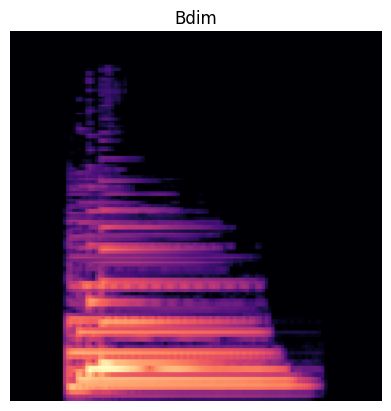

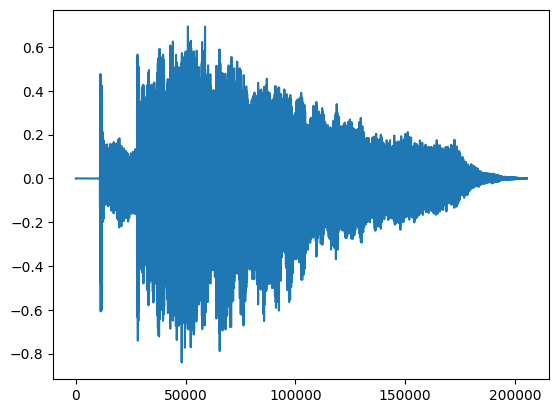

In [28]:
# Visualizamos nuestros acordes utilizando la función anterior

target_class = "Bdim"

view_random_image(target_dir="guitar-chords-v3/TrainingSpectograms/", target_class=target_class)
listen_random_wav(target_dir="guitar-chords-v3/Training/", target_class=target_class)

También puede ser util visualizar varios acordes a la vez

C


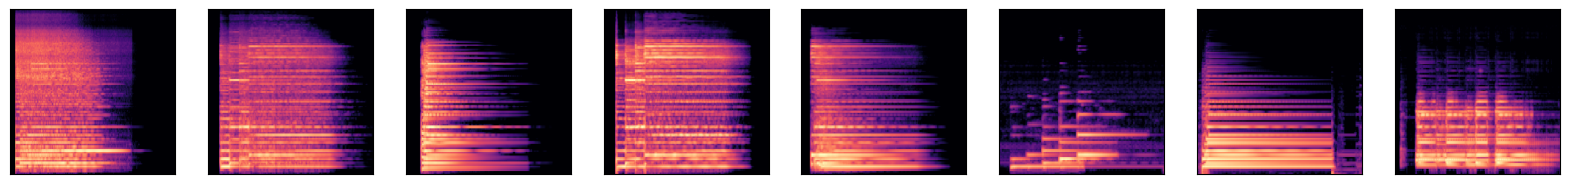

In [30]:
from keras.preprocessing import image
import random
import pathlib
import numpy as np
import os

def load_images_from_path(path, label):
    images = []
    labels = []
    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)


data_dir = pathlib.Path("guitar-chords-v3/TrainingSpectograms")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories


total_class_names = len(class_names)
class_key = random.randint(0, total_class_names)
images, labels = load_images_from_path(f"guitar-chords-v3/TrainingSpectograms/{class_names[class_key]}", class_key)

# Show first 10
random.shuffle(images)
print(class_names[class_key])
show_images(images[:10])

## 4. Preparar los datos con ImageDataGenerator

Genera lotes de datos de imágenes tensoriales con aumento de datos en tiempo real.
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Update paths to point to your spectrogram directories
train_dir = 'guitar-chords-v3/TrainingSpectograms'
val_dir = 'guitar-chords-v3/ValidationSpectograms'

# Load spectrogram images
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical'
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical'
)


Found 1440 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


## 5. Definir y entrenar el modelo CNN

https://poloclub.github.io/cnn-explainer/


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

tf.random.set_seed(42) # para asegurarnos que los resultados sean los mismos siempre

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_ds.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
45/45 [==============================] - 189s 4s/step - loss: 1.5845 - accuracy: 0.5104 - val_loss: 0.3434 - val_accuracy: 0.9031
Epoch 2/10
45/45 [==============================] - 198s 4s/step - loss: 0.1333 - accuracy: 0.9556 - val_loss: 0.2255 - val_accuracy: 0.9406
Epoch 3/10
45/45 [==============================] - 184s 4s/step - loss: 0.0491 - accuracy: 0.9840 - val_loss: 0.2323 - val_accuracy: 0.9531
Epoch 4/10
45/45 [==============================] - 165s 4s/step - loss: 0.0161 - accuracy: 0.9944 - val_loss: 0.2377 - val_accuracy: 0.9844
Epoch 5/10
45/45 [==============================] - 174s 4s/step - loss: 0.0106 - accuracy: 0.9965 - val_loss: 0.2138 - val_accuracy: 0.9563
Epoch 6/10
45/45 [==============================] - 175s 4s/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.3042 - val_accuracy: 0.9688
Epoch 7/10
45/45 [==============================] - 172s 4s/step - loss: 9.3841e-04 - accuracy: 1.0000 - val_loss: 0.2837 - val_accuracy: 0.9719
Epoch 8/1

## 6. Evaluar y Visualizar

Para evaluar nuestro modelo CNN de multi clasificación podriamos:
* Visualizar en gráficos la precisión y perdida del modelo.
* Evaluar su resultado utilizanod métrica de clasificación, como una matriz de confusión.
* Realizar predicciones aleatorias y visualizar el resultado


In [34]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy}")

10/10 [==============================] - 11s 1s/step - loss: 0.2876 - accuracy: 0.9719
Validation accuracy: 0.971875011920929


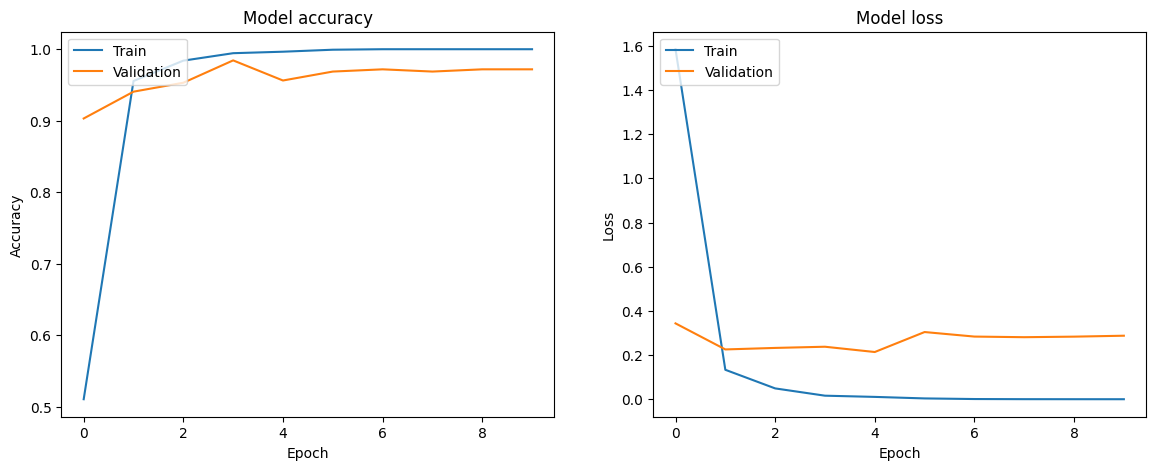

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 [==============================] - 1s 1s/step


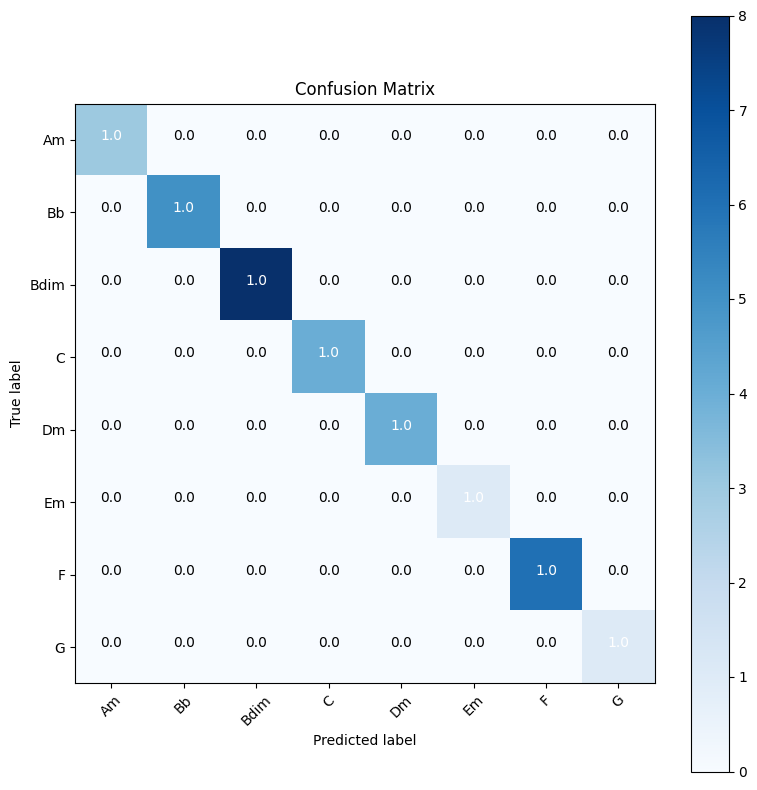

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

# Generate predictions for all validation images
val_images, val_labels = next(val_ds)  # This assumes that batch_size of val_ds is big enough to cover all validation data
predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(val_labels, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names=list(train_ds.class_indices.keys()))
plt.show()

## 7. Predicciones

Realizaremos predicciones con grabaciones propias de una gutarra.
Crearemos una carpeta UploadedWavs donde subiremos las grabaciones.

In [38]:
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)
predictions, predicted_classes

10/10 [==============================] - 12s 1s/step


(array([[1.2045371e-16, 1.3827695e-12, 2.1132138e-07, ..., 3.1666547e-14,
         1.4139413e-09, 5.2996774e-19],
        [5.0394369e-11, 3.1521640e-17, 6.0836096e-13, ..., 1.7942311e-13,
         1.2695605e-14, 6.5904073e-17],
        [2.1106927e-16, 9.9999982e-01, 7.7733461e-08, ..., 1.7523376e-12,
         1.3620631e-10, 1.0031480e-15],
        ...,
        [4.6814121e-19, 1.2202725e-14, 8.0244943e-11, ..., 2.1475790e-19,
         1.2960106e-11, 2.8381108e-26],
        [5.0369098e-11, 8.0734963e-19, 6.2911810e-16, ..., 2.7072271e-13,
         3.4680191e-15, 1.3989305e-16],
        [7.5929036e-14, 4.3702184e-04, 9.9956292e-01, ..., 1.8643565e-13,
         1.2748311e-13, 8.6194185e-12]], dtype=float32),
 array([4, 3, 1, 2, 6, 7, 4, 0, 2, 6, 5, 6, 5, 6, 7, 0, 6, 5, 2, 4, 4, 1,
        3, 5, 2, 1, 5, 5, 5, 6, 1, 0, 3, 5, 6, 4, 3, 1, 2, 2, 3, 7, 5, 3,
        7, 4, 1, 2, 0, 0, 7, 0, 3, 3, 2, 6, 6, 2, 0, 3, 4, 7, 2, 3, 5, 1,
        3, 5, 7, 2, 6, 6, 0, 2, 1, 7, 6, 1, 5, 4, 1, 5, 7, 5, 1,

In [49]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_and_plot_from_wav_file(wav_file_path, model, class_indices, target_size=(224, 224)):
    # Convert the .wav file to a spectrogram image
    create_spectrogram(wav_file_path, 'temp_spectrogram.png')

    # Display the sound player
    display(Audio(wav_file_path))

    # Load and preprocess the spectrogram image
    img = image.load_img('temp_spectrogram.png', target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Predict
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)
    predicted_class_name = list(class_indices.keys())[predicted_class_index[0]]

    # Plotting
    plt.figure(figsize=(10, 4))

    # Display spectrogram
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Spectrogram of the Uploaded Chord")
    plt.axis('off')

    # Display prediction
    plt.subplot(1, 2, 2)
    plt.bar(range(len(predictions[0])), predictions[0], color='skyblue')
    plt.title(f"Predicted: {predicted_class_name}")
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.xticks(range(len(predictions[0])), list(class_indices.keys()), rotation=90)

    plt.tight_layout()
    plt.show()

    print(f"Predicted class: {predicted_class_name}")
    return predicted_class_name



1/1 [==============================] - 0s 213ms/step


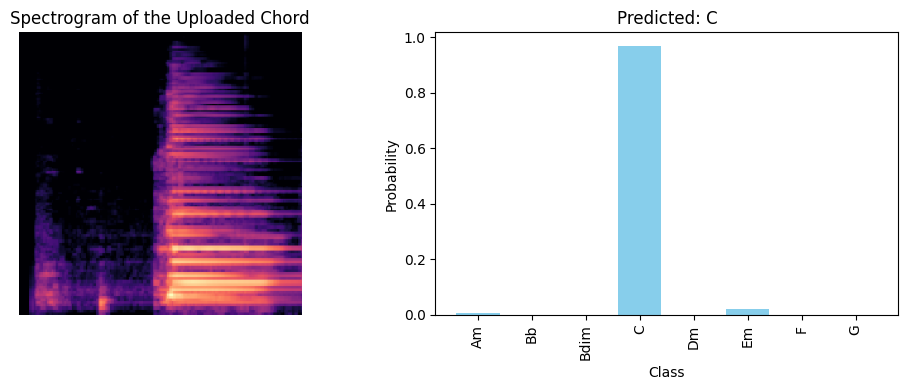

Predicted class: C


'C'

In [51]:

wav_file_path = 'UploadedWavs/C-Luis.wav'
class_indices = train_ds.class_indices

predict_and_plot_from_wav_file(wav_file_path, model, class_indices=class_indices)